# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from matplotlib_venn import venn2
from scipy.stats import mannwhitneyu
from sklearn.metrics import balanced_accuracy_score
from statsmodels.stats.multitest import multipletests
from utils import increase_stringency_CSF, print_p_val

# ignore pandas copy warning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature data sets

### Unfiltered

In [3]:
# all human proteins
df_human_proteome = pd.read_csv(data_path + "/Features/df_features.csv")

In [4]:
# drop non-sequence-based features
df_human_proteome.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

### MS filtered

In [5]:
# all proteins detected in brain
df_detected = pd.read_csv(data_path + "/Features/df_features_brain_detected_MS_filtered.csv")
# all proteins detected in brain that were not part of the training and testing (i.e. brain elevated) set
df_val = pd.read_csv(data_path + "/Features/df_features_brain_detected_val_MS_filtered.csv")
# all proteins elevated in brain
df_elevated = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")

## CSF

In [6]:
csf = pd.read_csv(data_path + "CSF/CSF.csv")

## Brain detected dataset (Human Protein Atlas)

In [7]:
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")

## Protein abundance (PaxDB)

In [8]:
brain_abundance = pd.read_csv(data_path + "Brain/Brain_protein_abundance_paxdb.txt", sep="\t", header=10, 
    names=["ID", "Ensembl", "Abundance"])

## Uniprot ID mapping

In [9]:
uniprot_mapping = pd.read_csv(data_path + "Uniprot/Human_proteome_Uniprot_Gene_name.tsv", sep="\t", header=0,
    names=["Uniprot", "Gene Names"])

## Model and scaler

In [10]:
with open(os.getcwd() + "/Models/LogisticClassifier_L2_1plus.pkl", "rb") as f:  
    L2_CSF1 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_2plus.pkl", "rb") as f:  
    L2_CSF2 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
    L2_CSF3 = pickle.load(f)

In [11]:
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

# Prediction on human proteome

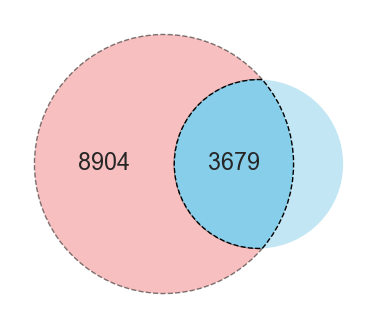

In [12]:
brain_detected_val_set = set(df_val["Uniprot"])
csf_set = set(csf["Uniprot"])

sns.set(style=("ticks"), font_scale=1.4)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# entire dataset
v = venn2([brain_detected_val_set, csf_set], ["", ""], set_colors=("lightcoral", "skyblue"), alpha=0.5)
v.get_patch_by_id("11").set_color("skyblue")
v.get_patch_by_id("11").set_alpha(1.0)
v.get_patch_by_id("11").set_linestyle("dashed")
v.get_patch_by_id("11").set_edgecolor("black")
v.get_patch_by_id("10").set_linestyle("dashed")
v.get_patch_by_id("10").set_edgecolor("black")
v.get_label_by_id("01").set_text("")
plt.show()

plt.show()
fig.savefig(fig_path + "Venn_CSF_brain_detected_val.png", bbox_inches="tight", dpi=300, transparent=True)

In [13]:
# define variables and target
X = df_human_proteome.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_human_proteome["CSF"]

# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Solubility', 'Disorder_NSP', 'Helix_NSP', 'Coil_NSP', 
        'Sheet_NSP', 'ExpAA', 'First60ExpAA', 'PredHel']

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

print("Number of features:", len(X.columns))

Number of features: 55


In [14]:
df_pred = df_human_proteome.copy()
models = [L2_CSF1, L2_CSF2, L2_CSF3]
model_names = ["L2_CSF1", "L2_CSF2", "L2_CSF3"]

for i, m in enumerate(models):
    # calculate probabilities with trained model
    proba = m.predict_proba(X_scal)
    # create dataframe of probabilities
    proba_df = pd.DataFrame(proba, columns=["non_CSF", "CSF"])
    # add probabilities to main dataframe
    df_pred[model_names[i]] = proba_df["CSF"]

# order dataframe by probabilities and reset index
df_pred.sort_values(by="L2_CSF1", ascending=False, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

## Create data subsets

In [15]:
df_elevated_pred = df_pred[df_pred["Uniprot"].isin(df_elevated["Uniprot"])]
print("Number of proteins in brain elevated set:", len(df_elevated_pred))

df_detected_pred = df_pred[df_pred["Uniprot"].isin(df_detected["Uniprot"])]
print("Number of proteins in brain detected set:", len(df_detected_pred))

df_val_pred = df_pred[df_pred["Uniprot"].isin(df_val["Uniprot"])]
print("Number of proteins in brain detected validation set:", len(df_val_pred))

Number of proteins in brain elevated set: 2079
Number of proteins in brain detected set: 14662
Number of proteins in brain detected validation set: 12583


In [16]:
# create datasets without ambiguous proteins
print("Brain elevated set")
print("CSF2+")
df_elevated_pred_CSF2 = increase_stringency_CSF(df_elevated_pred, csf, 2)
print("CSF3+")
df_elevated_pred_CSF3 = increase_stringency_CSF(df_elevated_pred, csf, 3)

print("--------------")
print("Brain detected validation set")
print("CSF2+")
df_val_pred_CSF2 = increase_stringency_CSF(df_val_pred, csf, 2)
print("CSF3+")
df_val_pred_CSF3 = increase_stringency_CSF(df_val_pred, csf, 3)

Brain elevated set
CSF2+
Number of CSF proteins to be removed: 243
Number of CSF proteins left: 649
CSF3+
Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525
--------------
Brain detected validation set
CSF2+
Number of CSF proteins to be removed: 1368
Number of CSF proteins left: 2311
CSF3+
Number of CSF proteins to be removed: 1934
Number of CSF proteins left: 1745


In [17]:
# create subsets of datasets based on CSF class annotation
print("Brain elevated set")
print("CSF1+ data set")
df_elevated_pred_CSF1_CSF = df_elevated_pred[df_elevated_pred["CSF"] == 1]
df_elevated_pred_CSF1_non_CSF = df_elevated_pred[df_elevated_pred["CSF"] == -1]
print("Number of CSF proteins in brain elevated set (CSF1+):", len(df_elevated_pred_CSF1_CSF))
print("Number of non-CSF proteins in brain elevated set (CSF1+):", len(df_elevated_pred_CSF1_non_CSF))
print("CSF2+ data set")
df_elevated_pred_CSF2_CSF = df_elevated_pred_CSF2[df_elevated_pred_CSF2["CSF"] == 1]
df_elevated_pred_CSF2_non_CSF = df_elevated_pred_CSF2[df_elevated_pred_CSF2["CSF"] == -1]
print("Number of CSF proteins in brain elevated set (CSF2+):", len(df_elevated_pred_CSF2_CSF))
print("Number of non-CSF proteins in brain elevated set (CSF2+):", len(df_elevated_pred_CSF2_non_CSF))
print("CSF3+ data set")
df_elevated_pred_CSF3_CSF = df_elevated_pred_CSF3[df_elevated_pred_CSF3["CSF"] == 1]
df_elevated_pred_CSF3_non_CSF = df_elevated_pred_CSF3[df_elevated_pred_CSF3["CSF"] == -1]
print("Number of CSF proteins in brain elevated set (CSF3+):", len(df_elevated_pred_CSF3_CSF))
print("Number of non-CSF proteins in brain elevated set (CSF3+):", len(df_elevated_pred_CSF3_non_CSF))

print("--------------")
print("Brain detected validation set")
print("CSF1+ data set")
df_val_pred_CSF1_CSF = df_val_pred[df_val_pred["CSF"] == 1]
df_val_pred_CSF1_non_CSF = df_val_pred[df_val_pred["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set (CSF1+):", len(df_val_pred_CSF1_CSF))
print("Number of non-CSF proteins in brain detected validation set (CSF1+):", len(df_val_pred_CSF1_non_CSF))
print("CSF2+ data set")
df_val_pred_CSF2_CSF = df_val_pred_CSF2[df_val_pred_CSF2["CSF"] == 1]
df_val_pred_CSF2_non_CSF = df_val_pred_CSF2[df_val_pred_CSF2["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set (CSF2+):", len(df_val_pred_CSF2_CSF))
print("Number of non-CSF proteins in brain detected validation set (CSF2+):", len(df_val_pred_CSF2_non_CSF))
print("CSF3+ data set")
df_val_pred_CSF3_CSF = df_val_pred_CSF3[df_val_pred_CSF3["CSF"] == 1]
df_val_pred_CSF3_non_CSF = df_val_pred_CSF3[df_val_pred_CSF3["CSF"] == -1]
print("Number of CSF proteins in brain detected validation set (CSF3+):", len(df_val_pred_CSF3_CSF))
print("Number of non-CSF proteins in brain detected validation set (CSF3+):", len(df_val_pred_CSF3_non_CSF))

Brain elevated set
CSF1+ data set
Number of CSF proteins in brain elevated set (CSF1+): 892
Number of non-CSF proteins in brain elevated set (CSF1+): 1187
CSF2+ data set
Number of CSF proteins in brain elevated set (CSF2+): 649
Number of non-CSF proteins in brain elevated set (CSF2+): 1187
CSF3+ data set
Number of CSF proteins in brain elevated set (CSF3+): 525
Number of non-CSF proteins in brain elevated set (CSF3+): 1187
--------------
Brain detected validation set
CSF1+ data set
Number of CSF proteins in brain detected validation set (CSF1+): 3679
Number of non-CSF proteins in brain detected validation set (CSF1+): 8904
CSF2+ data set
Number of CSF proteins in brain detected validation set (CSF2+): 2311
Number of non-CSF proteins in brain detected validation set (CSF2+): 8904
CSF3+ data set
Number of CSF proteins in brain detected validation set (CSF3+): 1745
Number of non-CSF proteins in brain detected validation set (CSF3+): 8904


### Define prediction classes (brain detected validation)

In [18]:
TP_CSF3 = df_val_pred_CSF1_CSF[df_val_pred_CSF1_CSF["L2_CSF3"] > 0.5]
print("Number of true positive proteins in CSF3+ brain validation dataset:", len(TP_CSF3))
FN_CSF3 = df_val_pred_CSF1_CSF[df_val_pred_CSF1_CSF["L2_CSF3"] < 0.5]
print("Number of false negative proteins in CSF3+ brain validation dataset:", len(FN_CSF3))
TN_CSF3 = df_val_pred_CSF1_non_CSF[df_val_pred_CSF1_non_CSF["L2_CSF3"] < 0.5]
print("Number of true negative proteins in CSF3+ brain validation dataset:", len(TN_CSF3))
FP_CSF3 = df_val_pred_CSF1_non_CSF[df_val_pred_CSF1_non_CSF["L2_CSF3"] > 0.5]
print("Number of false positive proteins in CSF3+ brain validation dataset:", len(FP_CSF3))

Number of true positive proteins in CSF3+ brain validation dataset: 1946
Number of false negative proteins in CSF3+ brain validation dataset: 1733
Number of true negative proteins in CSF3+ brain validation dataset: 7641
Number of false positive proteins in CSF3+ brain validation dataset: 1263


In [19]:
val_pred_CSF3_class = df_val_pred.copy()

val_pred_CSF3_class["Class"] = np.where(val_pred_CSF3_class["Uniprot"].isin(TP_CSF3["Uniprot"]), "TP", None)
val_pred_CSF3_class["Class"] = np.where(val_pred_CSF3_class["Uniprot"].isin(FN_CSF3["Uniprot"]), "FN", 
    val_pred_CSF3_class["Class"])
val_pred_CSF3_class["Class"] = np.where(val_pred_CSF3_class["Uniprot"].isin(TN_CSF3["Uniprot"]), "TN", 
    val_pred_CSF3_class["Class"])
val_pred_CSF3_class["Class"] = np.where(val_pred_CSF3_class["Uniprot"].isin(FP_CSF3["Uniprot"]), "FP", 
    val_pred_CSF3_class["Class"])

print("Total number of proteins:", val_pred_CSF3_class["Class"].value_counts().sum())

Total number of proteins: 12583


# Prediction results

## Brain elevated HPA proteome

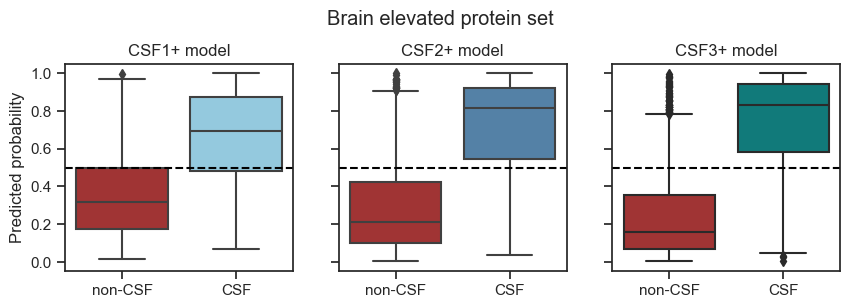

In [20]:
# brain elevated 
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.suptitle("Brain elevated protein set")
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)

sns.boxplot(x="CSF", y="L2_CSF1", data=df_elevated_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="CSF1+ model")
sns.boxplot(x="CSF", y="L2_CSF2", data=df_elevated_pred_CSF2, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="CSF2+ model")
sns.boxplot(x="CSF", y="L2_CSF3", data=df_elevated_pred_CSF3, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")

for i in range(3):
    ax[i].set_xticklabels(["non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_elevated_L2.png", bbox_inches="tight", dpi=300, transparent=True)

In [21]:
sens_CSF1 = len(df_elevated_pred_CSF1_CSF[df_elevated_pred_CSF1_CSF["L2_CSF1"] > 0.5])/len(df_elevated_pred_CSF1_CSF)
print("Correctly predicted CSF proteins (CSF1+): %.4f" % sens_CSF1)
sens_CSF2 = len(df_elevated_pred_CSF2_CSF[df_elevated_pred_CSF2_CSF["L2_CSF2"] > 0.5])/len(df_elevated_pred_CSF2_CSF)
print("Correctly predicted CSF proteins (CSF2+): %.4f" % sens_CSF2)
sens_CSF3 = len(df_elevated_pred_CSF3_CSF[df_elevated_pred_CSF3_CSF["L2_CSF3"] > 0.5])/len(df_elevated_pred_CSF3_CSF)
print("Correctly predicted CSF proteins (CSF3+): %.4f" % sens_CSF3)

Correctly predicted CSF proteins (CSF1+): 0.7298
Correctly predicted CSF proteins (CSF2+): 0.7735
Correctly predicted CSF proteins (CSF3+): 0.8019


In [22]:
spec_CSF1 = len(df_elevated_pred_CSF1_non_CSF[df_elevated_pred_CSF1_non_CSF["L2_CSF1"] < 0.5])/len(df_elevated_pred_CSF1_non_CSF)
print("Correctly predicted non-CSF proteins (CSF1+): %.4f" % spec_CSF1)
spec_CSF2 = len(df_elevated_pred_CSF2_non_CSF[df_elevated_pred_CSF2_non_CSF["L2_CSF2"] < 0.5])/len(df_elevated_pred_CSF2_non_CSF)
print("Correctly predicted non-CSF proteins (CSF2+): %.4f" % spec_CSF2)
spec_CSF3 = len(df_elevated_pred_CSF3_non_CSF[df_elevated_pred_CSF3_non_CSF["L2_CSF3"] < 0.5])/len(df_elevated_pred_CSF3_non_CSF)
print("Correctly predicted non-CSF proteins (CSF3+): %.4f" % spec_CSF3)

Correctly predicted non-CSF proteins (CSF1+): 0.7548
Correctly predicted non-CSF proteins (CSF2+): 0.8189
Correctly predicted non-CSF proteins (CSF3+): 0.8467


In [23]:
y_true = df_elevated_pred["CSF"]
y_pred = np.where(df_elevated_pred["L2_CSF1"] > 0.5, 1, -1)
y_true_CSF2 = df_elevated_pred_CSF2["CSF"]
y_pred_CSF2 = np.where(df_elevated_pred_CSF2["L2_CSF2"] > 0.5, 1, -1)
y_true_CSF3 = df_elevated_pred_CSF3["CSF"]
y_pred_CSF3 = np.where(df_elevated_pred_CSF3["L2_CSF3"] > 0.5, 1, -1)

print("Balanced accuracy (CSF1+): %.4f" % balanced_accuracy_score(y_true, y_pred))
print("Balanced accuracy (CSF2+): %.4f" % balanced_accuracy_score(y_true_CSF2, y_pred_CSF2))
print("Balanced accuracy (CSF3+): %.4f" % balanced_accuracy_score(y_true_CSF3, y_pred_CSF3))

Balanced accuracy (CSF1+): 0.7423
Balanced accuracy (CSF2+): 0.7962
Balanced accuracy (CSF3+): 0.8243


## Brain detected validation HPA proteome

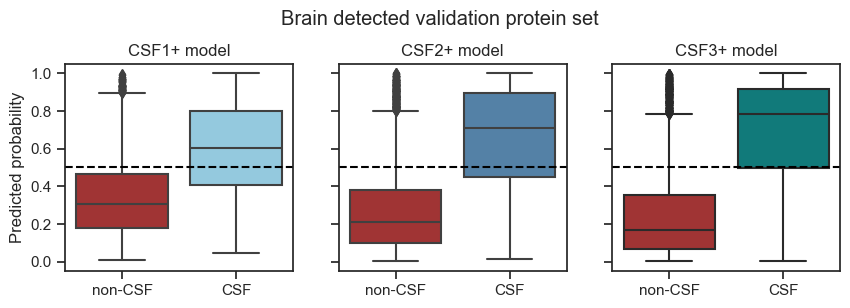

In [24]:
# brain detected validation
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8)
fig.suptitle("Brain detected validation protein set")

sns.boxplot(x="CSF", y="L2_CSF1", data=df_val_pred, palette=["firebrick", "skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="CSF1+ model")
sns.boxplot(x="CSF", y="L2_CSF2", data=df_val_pred_CSF2, palette=["firebrick", "steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="CSF2+ model")
sns.boxplot(x="CSF", y="L2_CSF3", data=df_val_pred_CSF3, palette=["firebrick", "darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")

for i in range(3):
    ax[i].set_xticklabels(["non-CSF", "CSF"])
    ax[i].axhline(0.5, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Probability_scores_brain_detected_val_L2.png", bbox_inches="tight", dpi=300, transparent=True)

In [25]:
sens_CSF1 = len(df_val_pred_CSF1_CSF[df_val_pred_CSF1_CSF["L2_CSF1"] > 0.5])/len(df_val_pred_CSF1_CSF)
print("Correctly predicted CSF proteins (CSF1+): %.4f" % sens_CSF1)
sens_CSF2 = len(df_val_pred_CSF2_CSF[df_val_pred_CSF2_CSF["L2_CSF2"] > 0.5])/len(df_val_pred_CSF2_CSF)
print("Correctly predicted CSF proteins (CSF2+): %.4f" % sens_CSF2)
sens_CSF3 = len(df_val_pred_CSF3_CSF[df_val_pred_CSF3_CSF["L2_CSF3"] > 0.5])/len(df_val_pred_CSF3_CSF)
print("Correctly predicted CSF proteins (CSF3+): %.4f" % sens_CSF3)

Correctly predicted CSF proteins (CSF1+): 0.6320
Correctly predicted CSF proteins (CSF2+): 0.7049
Correctly predicted CSF proteins (CSF3+): 0.7484


In [26]:
spec_CSF1 = len(df_val_pred_CSF1_non_CSF[df_val_pred_CSF1_non_CSF["L2_CSF1"] < 0.5])/len(df_val_pred_CSF1_non_CSF)
print("Correctly predicted non-CSF proteins (CSF1+): %.4f" % spec_CSF1)
spec_CSF2 = len(df_val_pred_CSF2_non_CSF[df_val_pred_CSF2_non_CSF["L2_CSF2"] < 0.5])/len(df_val_pred_CSF2_non_CSF)
print("Correctly predicted non-CSF proteins (CSF2+): %.4f" % spec_CSF2)
spec_CSF3 = len(df_val_pred_CSF3_non_CSF[df_val_pred_CSF3_non_CSF["L2_CSF3"] < 0.5])/len(df_val_pred_CSF3_non_CSF)
print("Correctly predicted non-CSF proteins (CSF3+): %.4f" % spec_CSF3)

Correctly predicted non-CSF proteins (CSF1+): 0.7896
Correctly predicted non-CSF proteins (CSF2+): 0.8504
Correctly predicted non-CSF proteins (CSF3+): 0.8582


In [27]:
y_true = df_val_pred["CSF"]
y_pred = np.where(df_val_pred["L2_CSF1"] > 0.5, 1, -1)
y_true_CSF2 = df_val_pred_CSF2["CSF"]
y_pred_CSF2 = np.where(df_val_pred_CSF2["L2_CSF2"] > 0.5, 1, -1)
y_true_CSF3 = df_val_pred_CSF3["CSF"]
y_pred_CSF3 = np.where(df_val_pred_CSF3["L2_CSF3"] > 0.5, 1, -1)

print("Balanced accuracy (CSF1+): %.4f" % balanced_accuracy_score(y_true, y_pred))
print("Balanced accuracy (CSF2+): %.4f" % balanced_accuracy_score(y_true_CSF2, y_pred_CSF2))
print("Balanced accuracy (CSF3+): %.4f" % balanced_accuracy_score(y_true_CSF3, y_pred_CSF3))

Balanced accuracy (CSF1+): 0.7108
Balanced accuracy (CSF2+): 0.7776
Balanced accuracy (CSF3+): 0.8033


### Prediction confidence across CSF study number

In [28]:
# merge CSF studies with probability scores
proba_val_across_study_number = df_val_pred[["Uniprot", "L2_CSF1", "L2_CSF2", "L2_CSF3"]].merge(csf[["Uniprot", "#Studies"]], 
    on="Uniprot", how="left")
proba_val_across_study_number["#Studies"].fillna(0, inplace=True)
proba_val_across_study_number["#Studies"] = proba_val_across_study_number["#Studies"].astype(int)

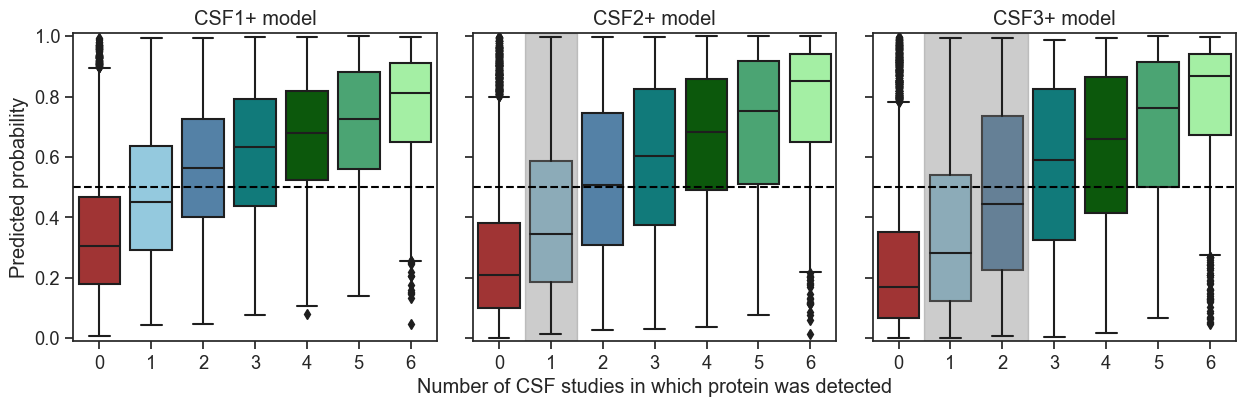

In [29]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=True)
fig.subplots_adjust(wspace=0.1)
plt.setp(ax, ylim=(-0.01, 1.01))

palette=["firebrick", "skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"]

sns.boxplot(x="#Studies", y="L2_CSF1", data=proba_val_across_study_number, palette=palette, ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="CSF1+ model")

sns.boxplot(x="#Studies", y="L2_CSF2", data=proba_val_across_study_number, palette=palette, ax=ax[1])
ax[1].set(xlabel="Number of CSF studies in which protein was detected", ylabel=None, title="CSF2+ model")
ax[1].axvspan(0.5, 1.5, color="grey", alpha=0.4)

sns.boxplot(x="#Studies", y="L2_CSF3", data=proba_val_across_study_number, palette=palette, ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="CSF3+ model")
ax[2].axvspan(0.5, 2.5, color="grey", alpha=0.4)

for i in range(3):
    ax[i].axhline(0.5, color="black", linestyle="--")
    
plt.show()
fig.savefig(fig_path + "Probability_scores_vs_study_number.png", bbox_inches="tight", dpi=300, transparent=True)

### Brain protein abundance across prediction classes

In [30]:
brain_abundance["Ensembl"] = brain_abundance["Ensembl"].apply(lambda x: x[5:])

# # save Ensembl IDs to text file to map to Uniprot
# with open(data_path + "Brain/Brain_protein_abundance_Ensembl.txt", "w") as f:
#     for item in liver_abundance["Ensembl"]:
#         f.write("%s\n" % item)

In [31]:
brain_abundance_uniprot = pd.read_csv(data_path + "Brain/Brain_protein_abundance_paxdb_Ensembl_Uniprot.tsv", sep="\t", 
    header=1, names=["Ensembl", "Uniprot"])
brain_abundance_uniprot 

,Ensembl,Uniprot
0,ENSP00000251595,P69905
1,ENSP00000322421,P69905
2,ENSP00000468500,A0A1X7SCE1
3,ENSP00000229239,P04406
4,ENSP00000299198,P12277
...,...,...
10803,ENSP00000276297,Q96QB1
10804,ENSP00000369497,P51587
10805,ENSP00000351346,Q7Z7G8
10806,ENSP00000262442,Q9NYC9


In [32]:
# handle 0 values for log2 transformation
brain_abundance["Abundance"] = np.where(brain_abundance["Abundance"] > 0.0001, np.log2(brain_abundance["Abundance"]), 
    brain_abundance["Abundance"])

# merge with Uniprot ID mapping table, remove duplicate Uniprots
brain_abundance = brain_abundance.merge(brain_abundance_uniprot, on="Ensembl", how="inner")
brain_abundance.drop_duplicates(subset=["Uniprot"], inplace=True)
brain_abundance

C:\Users\kathi\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID,Ensembl,Abundance,Uniprot
0,4434183,ENSP00000251595,13.873732,P69905
2,4450881,ENSP00000468500,13.559616,A0A1X7SCE1
3,4433451,ENSP00000229239,13.484949,P04406
4,4437548,ENSP00000299198,12.989572,P12277
5,4437206,ENSP00000295897,12.969746,P02768
...,...,...,...,...
10803,4436217,ENSP00000276297,0.000000,Q96QB1
10804,4445332,ENSP00000369497,0.000000,P51587
10805,4442136,ENSP00000351346,0.000000,Q7Z7G8
10806,4435084,ENSP00000262442,0.000000,Q9NYC9


In [33]:
val_pred_CSF3_brain_abundance = val_pred_CSF3_class.merge(brain_abundance[["Abundance", "Uniprot"]])
print("Number of proteins with brain protein abundance information:", val_pred_CSF3_brain_abundance["Class"].value_counts().sum())

Number of proteins with brain protein abundance information: 7796


In [34]:
# calculate p-values
_, p_FN_TP = mannwhitneyu(val_pred_CSF3_brain_abundance[val_pred_CSF3_brain_abundance["Class"] == "FN"]["Abundance"],
    val_pred_CSF3_brain_abundance[val_pred_CSF3_brain_abundance["Class"] == "TP"]["Abundance"])
_, p_FN_FP = mannwhitneyu(val_pred_CSF3_brain_abundance[val_pred_CSF3_brain_abundance["Class"] == "FN"]["Abundance"],
    val_pred_CSF3_brain_abundance[val_pred_CSF3_brain_abundance["Class"] == "FP"]["Abundance"])
_, p_FN_TN = mannwhitneyu(val_pred_CSF3_brain_abundance[val_pred_CSF3_brain_abundance["Class"] == "FN"]["Abundance"],
    val_pred_CSF3_brain_abundance[val_pred_CSF3_brain_abundance["Class"] == "TN"]["Abundance"])

# adjust p-values
adjusted_p_expression = multipletests([p_FN_TP, p_FN_FP, p_FN_TN], alpha=0.05, method="fdr_bh")[1]

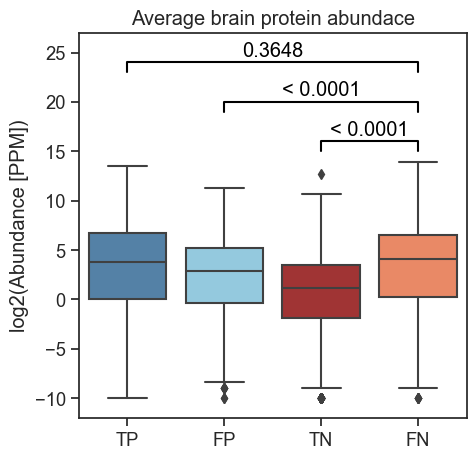

In [35]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

ax = sns.boxplot(data=val_pred_CSF3_brain_abundance, x="Class", y="Abundance", order=["TP", "FP", "TN", "FN"], 
    palette=["steelblue", "skyblue", "firebrick", "coral"])
ax.set(title="Average brain protein abundace", xlabel=None, ylabel="log2(Abundance [PPM])", ylim=(-12,27))

# add p-value annotations
# TP
y, h = 23, 1
ax.plot([0, 0, 3, 3], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(1.5, y+1.2, print_p_val(adjusted_p_expression[0]), ha="center", va="bottom", color="black")
# FP
y, h = 19, 1
ax.plot([1, 1, 3, 3], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(2, y+1.2, print_p_val(adjusted_p_expression[1]), ha="center", va="bottom", color="black")
# TN
y, h = 15, 1
ax.plot([2, 2, 3, 3], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(2.5, y+1.2, print_p_val(adjusted_p_expression[2]), ha="center", va="bottom", color="black")

plt.show()
fig.savefig(fig_path + "Brain_abundance_across_predicted_classes.png", bbox_inches="tight", dpi=300, transparent=True)

### RNA tissue specifcity

In [36]:
# merge with RNA tissue inforamtion
val_pred_CSF3_spec = val_pred_CSF3_class.merge(brain_detected[["Uniprot", "RNA tissue specificity"]])

# get counts per RNA specificity class
counts_spec = val_pred_CSF3_spec[["Class", "RNA tissue specificity"]].value_counts().unstack()
# change column order
counts_spec = counts_spec[["Low tissue specificity", "Group enriched", "Tissue enhanced", "Tissue enriched"]]
# get proportions per row (per prediction class)
counts_prop = counts_spec.div(counts_spec.sum(axis=1), axis=0).reindex(["TP", "FP", "TN", "FN"])

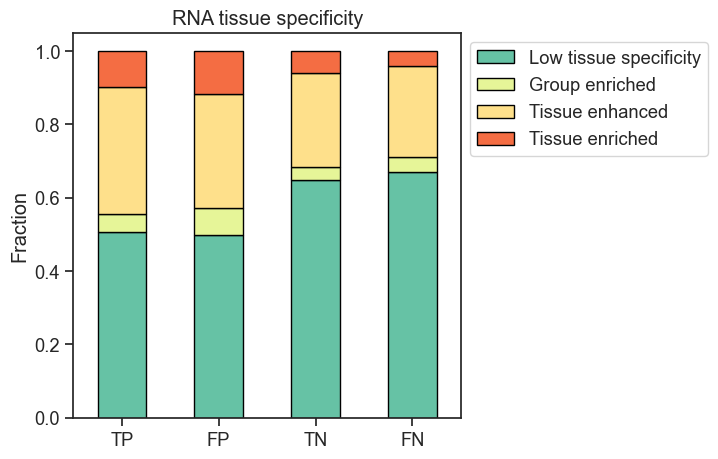

In [37]:
sns.set(style=("ticks"), font_scale=1.2 , palette=sns.color_palette("Spectral_r", 4))
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

counts_prop.plot(kind="bar", stacked=True, edgecolor="black", ax=ax)
ax.set(title="RNA tissue specificity", xlabel=None, ylabel="Fraction")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=0)

plt.show()
fig.savefig(fig_path + "RNA_tissue_specificity_across_prediction_classes.png", bbox_inches="tight", dpi=300, transparent=True)

### RNA tissue distribution

In [38]:
# merge with RNA tissue inforamtion
val_pred_CSF3_dist = val_pred_CSF3_class.merge(brain_detected[["Uniprot", "RNA tissue distribution"]])

# get counts per RNA distribution class
counts_spec = val_pred_CSF3_dist[["Class", "RNA tissue distribution"]].value_counts().unstack()
# change column order
counts_spec = counts_spec[["Detected in all", "Detected in many", "Detected in some", "Detected in single"]]
# get proportions per row (per prediction class)
counts_prop = counts_spec.div(counts_spec.sum(axis=1), axis=0).reindex(["TP", "FP", "TN", "FN"])

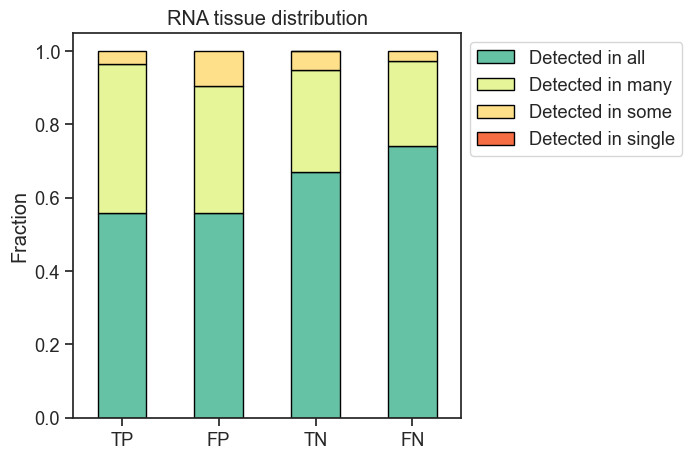

In [39]:
sns.set(style=("ticks"), font_scale=1.2 , palette=sns.color_palette("Spectral_r", 4))
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True)

counts_prop.plot(kind="bar", stacked=True, edgecolor="black", ax=ax)
ax.set(title="RNA tissue distribution", xlabel=None, ylabel="Fraction")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=0)

plt.show()
fig.savefig(fig_path + "RNA_tissue_distribution_across_prediction_classes.png", bbox_inches="tight", dpi=300, transparent=True)

### Brain region expression

In [40]:
column_list = ["Uniprot"]
column_list.extend(list(brain_detected.columns[224:237]))
brain_detected_brain_region = brain_detected[column_list]
brain_detected_brain_region

,Uniprot,Brain RNA - amygdala [nTPM],Brain RNA - basal ganglia [nTPM],Brain RNA - cerebellum [nTPM],Brain RNA - cerebral cortex [nTPM],Brain RNA - hippocampal formation [nTPM],Brain RNA - hypothalamus [nTPM],Brain RNA - medulla oblongata [nTPM],Brain RNA - midbrain [nTPM],Brain RNA - olfactory bulb [nTPM],Brain RNA - pons [nTPM],Brain RNA - spinal cord [nTPM],Brain RNA - thalamus [nTPM],Brain RNA - white matter [nTPM]
0,P01023,166.1,145.4,154.8,225.4,138.6,180.6,187.2,149.9,113.5,178.4,171.7,178.5,210.6
1,A8K2U0,2.5,2.0,1.3,2.5,2.0,1.7,2.0,2.1,1.6,1.6,1.5,2.8,1.3
2,Q9NPC4,5.2,4.8,4.2,8.1,5.0,9.1,6.6,4.5,3.8,4.4,4.6,6.2,6.1
3,Q9NRG9,11.9,14.2,13.8,15.7,12.0,12.4,13.3,13.3,11.6,13.9,12.4,12.7,16.4
4,Q86V21,4.9,8.6,3.3,11.3,9.1,5.1,6.5,4.2,7.3,6.9,2.7,4.9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16016,Q2QGD7,7.1,8.4,8.1,8.7,5.9,6.3,9.0,7.2,6.0,8.6,7.0,7.2,14.2
16017,Q9C0D3,11.5,15.3,16.7,13.5,13.0,16.0,8.8,11.3,13.1,10.6,7.6,14.3,15.3
16018,Q15942,20.7,22.7,21.7,33.7,19.5,23.9,24.3,22.4,17.8,24.7,23.7,24.0,29.3
16019,O43149,5.6,6.1,6.7,6.6,6.5,5.5,7.2,6.5,4.8,9.1,5.4,7.5,6.9


In [41]:
# merge with brain region expression information
val_pred_CSF3_brain_region = val_pred_CSF3_class[["Uniprot", "Class"]].merge(brain_detected_brain_region)
val_pred_CSF3_brain_region = val_pred_CSF3_brain_region.drop(["Uniprot"], axis=1)

# get only brain region
val_pred_CSF3_brain_region.columns = val_pred_CSF3_brain_region.columns.str.replace("Brain RNA - ", "", regex=False)
val_pred_CSF3_brain_region.columns = val_pred_CSF3_brain_region.columns.str.replace(" [nTPM]", "", regex=False)

val_pred_CSF3_brain_region_melt = val_pred_CSF3_brain_region.melt(id_vars="Class", value_vars=None, var_name="Variable", 
    value_name="RNA Expression")
val_pred_CSF3_brain_region_melt["RNA Expression"] = np.where(val_pred_CSF3_brain_region_melt["RNA Expression"] > 0.0001, 
    np.log2(val_pred_CSF3_brain_region_melt["RNA Expression"]), val_pred_CSF3_brain_region_melt["RNA Expression"])

C:\Users\kathi\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


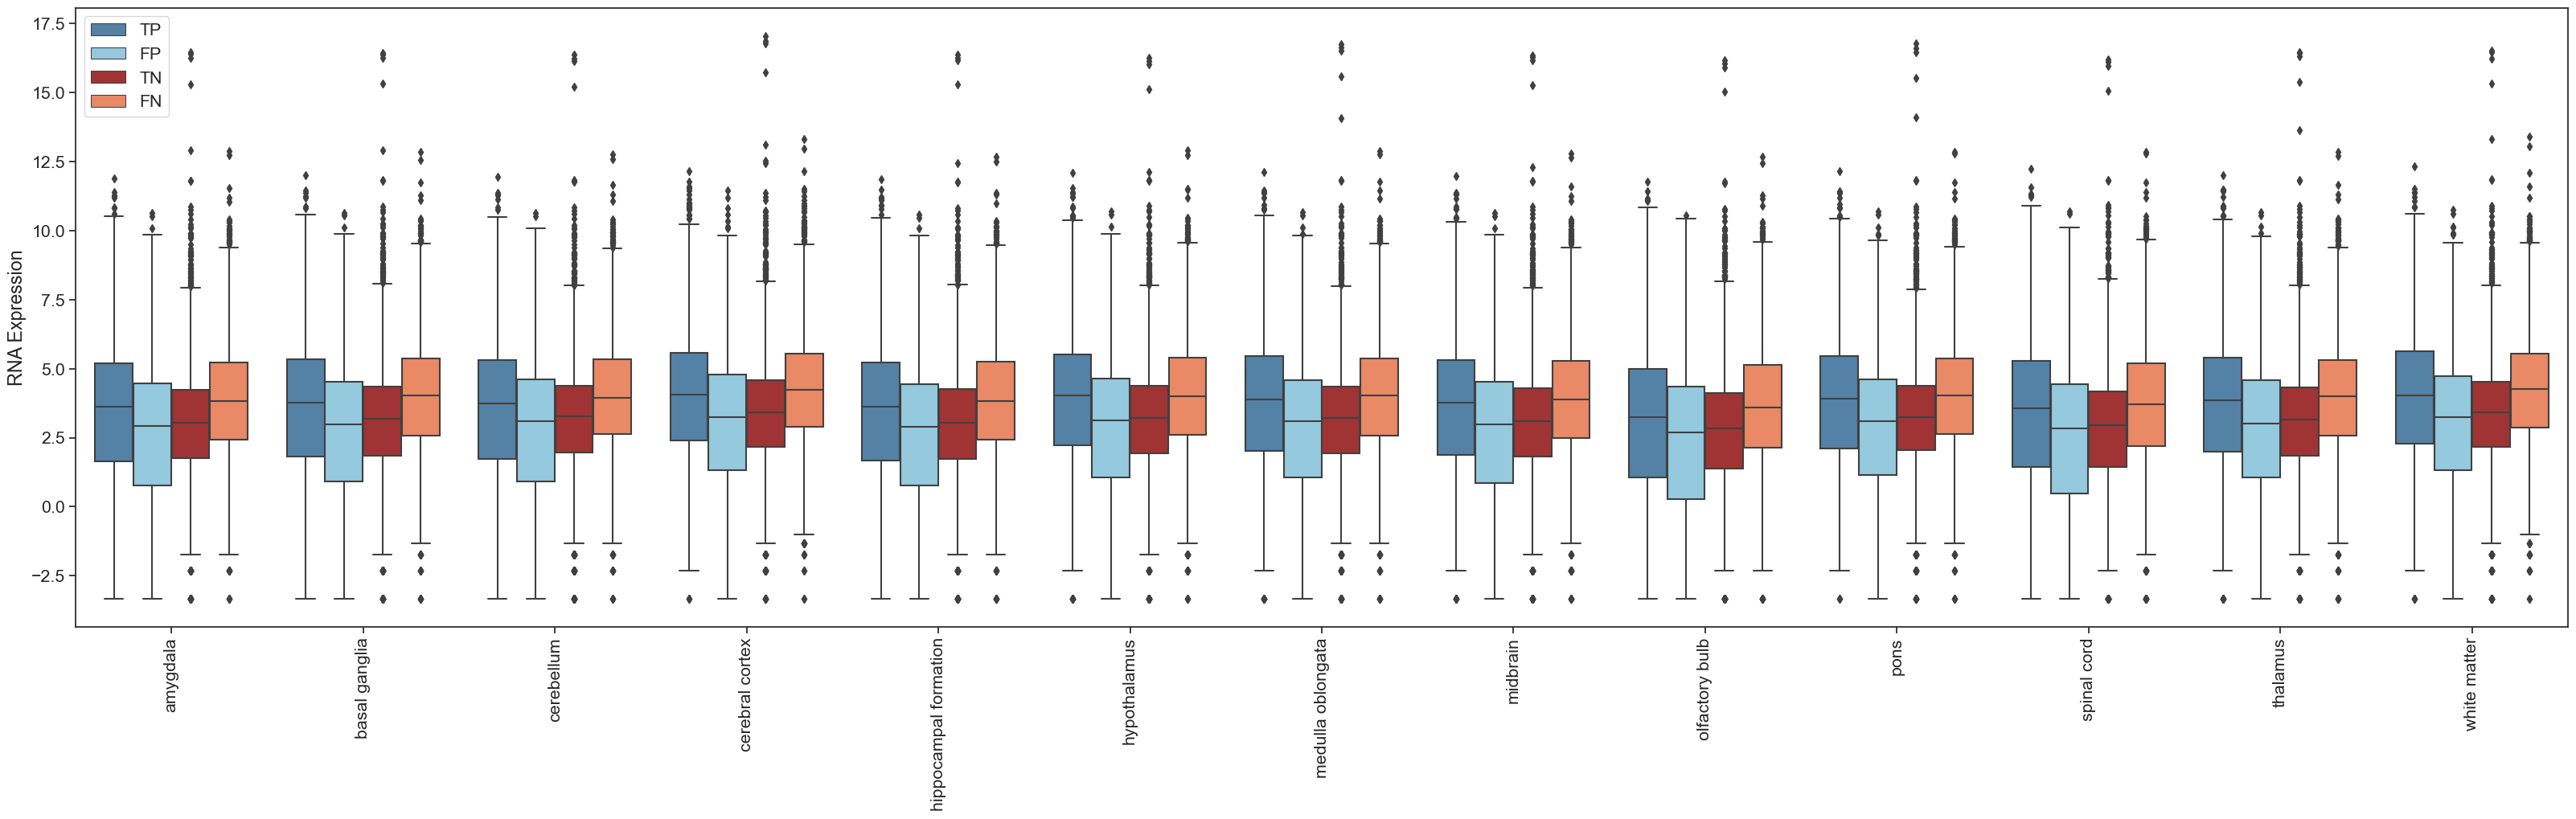

In [42]:
sns.set(style=("ticks"), font_scale=1.4)
fig, ax = plt.subplots(1, 1, figsize=(40, 10))

sns.boxplot(data=val_pred_CSF3_brain_region_melt, x="Variable", y="RNA Expression", hue="Class", 
    hue_order=["TP", "FP", "TN", "FN"], palette=["steelblue", "skyblue", "firebrick", "coral"])
plt.xticks(rotation=90)
ax.set(xlabel=None)

plt.legend()
plt.show()

## Model accuracy across model probability cut-offs

In [43]:
proba_val = proba_val_across_study_number.sort_values(by="L2_CSF3")[["L2_CSF3", "#Studies"]]
# remove one- and two-study CSF proteins
proba_val = proba_val[proba_val["#Studies"].isin([0, 3, 4, 5, 6])]
# classify as CSF and non-CSF
proba_val["CSF"] = np.where(proba_val["#Studies"] == 0, -1, 1)

cutoffs = np.arange(0, 1.05, 0.05)
sens = []
spec = []

for cutoff in cutoffs:
    sens.append(len(proba_val[(proba_val["CSF"] == 1) & (proba_val["L2_CSF3"] >= cutoff)]) / 
        len(proba_val[proba_val["CSF"] == 1]))
    spec.append(len(proba_val[(proba_val["CSF"] == -1) & (proba_val["L2_CSF3"] < cutoff)]) / 
        len(proba_val[proba_val["CSF"] == -1]))
    
print("Cut-off Sensitivity \tSpecificity")
for i in range(len(sens)):
    print("%.2f \t%.5f \t%.5f" %(cutoffs[i], sens[i]*100, spec[i]*100))

Cut-off Sensitivity 	Specificity
0.00 	100.00000 	0.00000
0.05 	99.42693 	19.66532
0.10 	97.76504 	34.99551
0.15 	95.81662 	46.52965
0.20 	93.69628 	55.40207
0.25 	91.40401 	63.30863
0.30 	88.53868 	69.60916
0.35 	84.87106 	74.67430
0.40 	81.89112 	79.29021
0.45 	78.51003 	82.89533
0.50 	74.84241 	85.81536
0.55 	71.34670 	88.06155
0.60 	66.87679 	90.01572
0.65 	63.15186 	91.81267
0.70 	58.68195 	93.22776
0.75 	53.40974 	94.62040
0.80 	47.79370 	96.05795
0.85 	40.05731 	97.09119
0.90 	29.62751 	98.13567
0.95 	15.53009 	99.31491
1.00 	0.00000 	100.00000


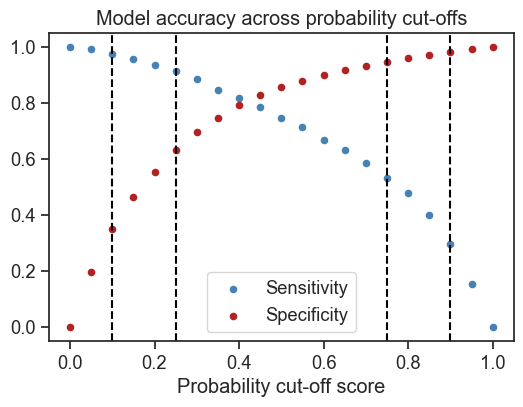

In [44]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(6,4))

scatter1 = plt.scatter(x=cutoffs, y=sens, s=20, color="steelblue", label="Sensitivity")
scatter2 = plt.scatter(x=cutoffs, y=spec, s=20, color="firebrick", label="Specificity")

plt.legend(handles=[scatter1, scatter2], loc="lower center")
ax.set(title="Model accuracy across probability cut-offs", xlabel="Probability cut-off score")
ax.axvline(0.1, color="black", linestyle="--")
ax.axvline(0.25, color="black", linestyle="--")
ax.axvline(0.75, color="black", linestyle="--")
ax.axvline(0.9, color="black", linestyle="--")

plt.show()
fig.savefig(fig_path + "Sensitivity_specificity_CSF3+_brain_detected.png", bbox_inches="tight", dpi=300, transparent=True)

# Save prediction dataframe

In [45]:
df_full_results = df_pred[["Uniprot", "L2_CSF1", "L2_CSF2", "L2_CSF3"]]

In [46]:
# merge CSF studies with probability scores
df_full_results = df_full_results.merge(csf[["Uniprot", "#Studies"]], on="Uniprot", how="left")
df_full_results["#Studies"].fillna(0, inplace=True)
df_full_results["#Studies"] = df_full_results["#Studies"].astype(int)

In [47]:
df_full_results["Detected in the brain"] = np.where(df_full_results["Uniprot"].isin(df_detected["Uniprot"]), "Yes", "No")
df_full_results["Part of the training data"] = np.where(df_full_results["Uniprot"].isin(df_elevated["Uniprot"]), "Yes", "No")

In [48]:
df_full_results.columns = ["Uniprot", "Probability score (CSF1+ model)", 
    "Probability score (CSF2+ model)", "Probability score (CSF3+ model)",
    "Number of CSF studies", "Part of the brain detected HPA proteome", "Part of the training data"]

In [49]:
df_full_results = uniprot_mapping.merge(df_full_results, on="Uniprot", how="right")

In [50]:
df_full_results[:5]

,Uniprot,Gene Names,Probability score (CSF1+ model),Probability score (CSF2+ model),Probability score (CSF3+ model),Number of CSF studies,Part of the brain detected HPA proteome,Part of the training data
0,Q7Z5P9,MUC19,0.999955,0.999863,0.998660,1,No,No
1,Q8WXI7,MUC16 CA125,0.999718,0.992367,0.413202,2,No,No
2,Q02817,MUC2 SMUC,0.999711,0.998488,0.995803,0,No,No
3,E2RYF6,MUC22 G4 PBMUCL1,0.999502,0.996012,0.999614,0,No,No
4,P15502,ELN,0.999405,0.999890,0.999907,5,Yes,No


In [51]:
df_full_results.to_excel(data_path + "Biomarker_discovery/Probability_scores_human_proteome.xlsx", index=False)